![logo](../../../LogoLine_horizon_C3S.png)

<div class="alert alert-block alert-warning">
Please note that this repository is used for development and review, so quality assessments should be considered work in progress until they are merged into the main branch
</div>

# Satellite Soil Moisture Data for Drought Detection in Europe

Production date: 16-June-2024

Produced by: Amaya Camila Trigoso Barrientos (VUB)

## 🌍 Use case: Drought detection and monitoring on a regional level

## ❓ Quality assessment question(s)
* **Can satellite soil moisture data be used to detect the historically reported drought of 2023 in Europe?**

Accurate soil moisture data is critical for monitoring droughts. The Copernicus Climate Change Service (C3S) provides the Combined Surface Soil Moisture (C3S-SM-COMBINED) product, which integrates active and passive microwave satellite observations to estimate surface (top few centimeters) soil moisture at a high temporal resolution (ICDR updated on a 10-day cycle). This study evaluates the usability of this dataset for tracking drought evolution across Europe in the warm season of 2023. The analysis focuses on dekadal anomalies of surface soil moisture (SSMA) from April to July 2023, highlighting regional differences, data coverage, and consistency with reported drought conditions.

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* The C3S surface soil moisture product is a valuable Essential Climate Variable (ECV) for tracking agricultural drought, especially when used alongside complementary indicators like root zone soil moisture, precipitation anomalies, and vegetation indices.
* The COMBINED product successfully captures the intense drought in the Iberian Peninsula during spring 2023, consistent with observed heatwaves and low rainfall.
* Coverage in Scandinavia and the Nordic region is still limited in spring due to snow, highlighting a known limitation of satellite-based soil moisture retrieval under frozen or snow-covered conditions.

```

## 📋 Methodology

The analysis and results are organized in the following steps, which are detailed in the sections below:

**[](satellite_satellite-soil-moisture_extremes-detection_q02:section-1)**
 * Download the combined passive and active satellite soil moisture data from 1991 to 2023. Select the volumetric_surface_soil_moisture variable and choose the 10-day average as the time aggregation option.

**[](satellite_satellite-soil-moisture_extremes-detection_q02:section-2)**
 * Extract soil moisture data in Europe.
 * Calculate the dekad mean and standard deviation for the long-term period 1991 to 2020.
 * Extract 2023 data into a separate set. 
 * Calculate the SSMA for 2023 in relation to the long-term period data.

**[](satellite_satellite-soil-moisture_extremes-detection_q02:section-3)**
 * Map the SSMA in Europe for Spring-Mid Summer 2023.
 * Plot the mean SSMA over time for specific regions.
 * Analyze the results.
 

## 📈 Analysis and results

(satellite_satellite-soil-moisture_extremes-detection_q02:section-1)=
### 1. Request and download data

#### Import packages

In [104]:
import xarray as xr
import numpy as np
import fsspec
import os
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import shapely.geometry
from shapely.geometry import Point
from shapely.geometry import MultiPolygon
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from c3s_eqc_automatic_quality_control import download
from matplotlib import animation, pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import path
import matplotlib.dates as mdates
import rioxarray as rxr
import requests
import zipfile
os.environ["CDSAPI_RC"] = os.path.expanduser("~/trigoso_camila/.cdsapirc")
plt.style.use("seaborn-v0_8-notebook")

#### Set variables

In [2]:
shapefile_url = "https://figshare.com/ndownloader/files/23392280"

#### Set the data request

In [52]:
collection_id = "satellite-soil-moisture"
request = {
    "variable": ["volumetric_surface_soil_moisture"],
    "type_of_sensor": ["combined_passive_and_active"],
    "time_aggregation": ["10_day_average"],
    "year": [
        "1991", "1992", "1993",
        "1994", "1995", "1996",
        "1997", "1998", "1999",
        "2000", "2001", "2002",
        "2003", "2004", "2005",
        "2006", "2007", "2008",
        "2009", "2010", "2011",
        "2012", "2013", "2014",
        "2015", "2016", "2017",
        "2018", "2019", "2020",
        "2021", "2022", "2023"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "day": ["01", "11", "21"],
    "type_of_record": ["cdr"],
    "version": ["v202312"]
}

#### Download data

In [53]:
# Dataset
ds = download.download_and_transform(
    collection_id,
    request,
    chunks={"year": 1},
    transform_chunks=False,
)


# Shapefile
with fsspec.open(f"simplecache::{shapefile_url}") as file:
    world_shape = geopandas.read_file(file)

  0%|          | 0/33 [00:00<?, ?it/s]2025-05-30 13:58:16,664 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-05-30 13:58:16,859 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-05-30 13:58:17,533 INFO Request ID is 967eb086-6518-4236-90a7-8d566f97c596
2025-05-30 13:58:17,577 INFO status has been updated to accepted
2025-05-30 13:58:52,919 INFO status has been updated to running
2025-05-30 13:59:10,025 INFO status has been updated to successful

86ae92af8d0f26fa9731dcfbdac52901.zip:   0%|          | 0.00/23.6M [00:00<?, ?B/s]
86ae92af8d0f26fa9731dcfbdac52901.zip:  17%|█▋        | 4.00M/23.6M [00:00<00:00, 39.8MB/s]
86ae92af8d0f26fa9731dcfbdac52901.zip:  59%|█████▉    | 14.0M/23.6M [00:00<00:00, 74.1MB/s]
                                                                                          
  3%|▎         | 1/33 [00:55<29:40, 

(satellite_satellite-soil-moisture_extremes-detection_q02:section-2)=
### 2. Calculate Surface Soil Moisture Anomaly

The Surface Soil Moisture Anomaly (referred to as SSMA hereafter) was calculated following a similar approach as the one explained by the European Drought Observatory (EDO) [[1]](https://drought.emergency.copernicus.eu/data/factsheets/factsheet_soilmoisture.pdf). Surface soil moisture values for each pixel and each dekad from April to July 2023 were compared to the long-term climatological period (1991–2020, 30 years). The anomaly was computed using the following equation:

$\text{SMA} = \frac{\text{SMI}_t - \overline{\text{SMI}}}{\delta_{\text{SMI}}}$

where:

$\text{SMI}_t$ = Surface soil moisture 2023 for a specific dekad for that pixel

$\overline{\text{SMI}}$ = Mean surface soil moisture 1991-2020 for that same dekad for that pixel

$\delta_{\text{SMI}}$ = Standard deviation surface soil moisture 1991-2020 for that same dekad for that pixel

In [5]:
#Select soil mouisture variable
da=ds["sm"]
# Filter the shapefile to keep only Europe
europe_shape = world_shape[world_shape['CONTINENT'] == 'Europe']
# Ensure soil_moisture has CRS information compatible with europe_shape (e.g., EPSG:4326)
da.rio.write_crs("EPSG:4326", inplace=True)
# Clip soil moisture data to the Europe shape
da_eu = da.rio.clip(europe_shape.geometry, europe_shape.crs, drop=True)

In [54]:
# Select data for the two time intervals.
da_long_term = da_eu.sel(time=slice("1991-01-01", "2020-12-21"))

#Group by day of th year and them calculate the mean and standard deviation.
#The available days in each month are 1, 11 and 21, 
#they correspont to the 1st, 2nd and 3rd dekad of the month.
doy_long_term = da_long_term.groupby("time.dayofyear")
mean_smi_long_term = doy_long_term.mean(dim="time")
std_smi_long_term = doy_long_term.std(dim="time")

In [8]:
#Select the data of the year 2023 and calculate the mean same as before.
da_2023 = da_eu.sel(time=slice("2023-01-01", "2023-12-21"))
doy_2023 = da_2023.groupby("time.dayofyear")
smi_2023 = doy_2023.mean(dim="time")

In [55]:
# Replace zeros in std with NaNs to avoid division by zero
std_smi_long_term_safe = std_smi_long_term.where(std_smi_long_term != 0)

# Calculate SMA safely
sma = (smi_2023 - mean_smi_long_term) / std_smi_long_term_safe

sma = sma.where(np.isfinite(sma))  # Replace inf/-inf with NaN

(satellite_satellite-soil-moisture_extremes-detection_q02:section-3)=
### 3. SSMA visualization

#### Map of Europe SSMA

In [87]:
# Define custom colormap and boundaries
colors = [
    "#b35806ff",  # <-2
    "#f1a340ff",  # -2 to -1.5
    "#fee0b6ff",  # -1.5 to -1
    "#ffffffff",  # -1 to 1
    "#d1e5f0ff",  # 1 to 1.5
    "#67a9cfff",  # 1.5 to 2
    "#2166acff"   # >= 2
]
bounds = [-100, -2, -1.5, -1, 1, 1.5, 2, 100]  # Define boundaries

# Create colormap and norm
cmap = mcolors.ListedColormap(colors)
cmap.set_bad(color='lightgray')  # Gray for no data
norm = mcolors.BoundaryNorm(bounds, ncolors=len(colors), clip=True)

In [108]:
boxes = [
    {
        'label': 'Iberian Peninsula', 
        'min_lat': 35, 'max_lat': 44, 
        'min_lon': -10, 'max_lon': 5, 
        'color': 'red'
    },
    {
        'label': 'Great Britain and Ireland', 
        'min_lat': 50, 'max_lat': 60, 
        'min_lon': -11, 'max_lon': 2, 
        'color': 'orange'},

    {
        'label': 'Southern Balkans and South Italy',
        'min_lat': 36, 'max_lat': 47,
        'min_lon': 7, 'max_lon': 24,
        'color': 'green'
    },
    {
        'label': 'Nordic and Baltic region',
        'min_lat': 55, 'max_lat': 71,
        'min_lon': 5, 'max_lon': 28,
        'color': 'blue'
    },

    {
        'label': 'Germany–Benelux–Poland',
        'min_lat': 48, 'max_lat': 54,
        'min_lon': 4, 'max_lon': 25,
        'color': 'purple'
    }
]

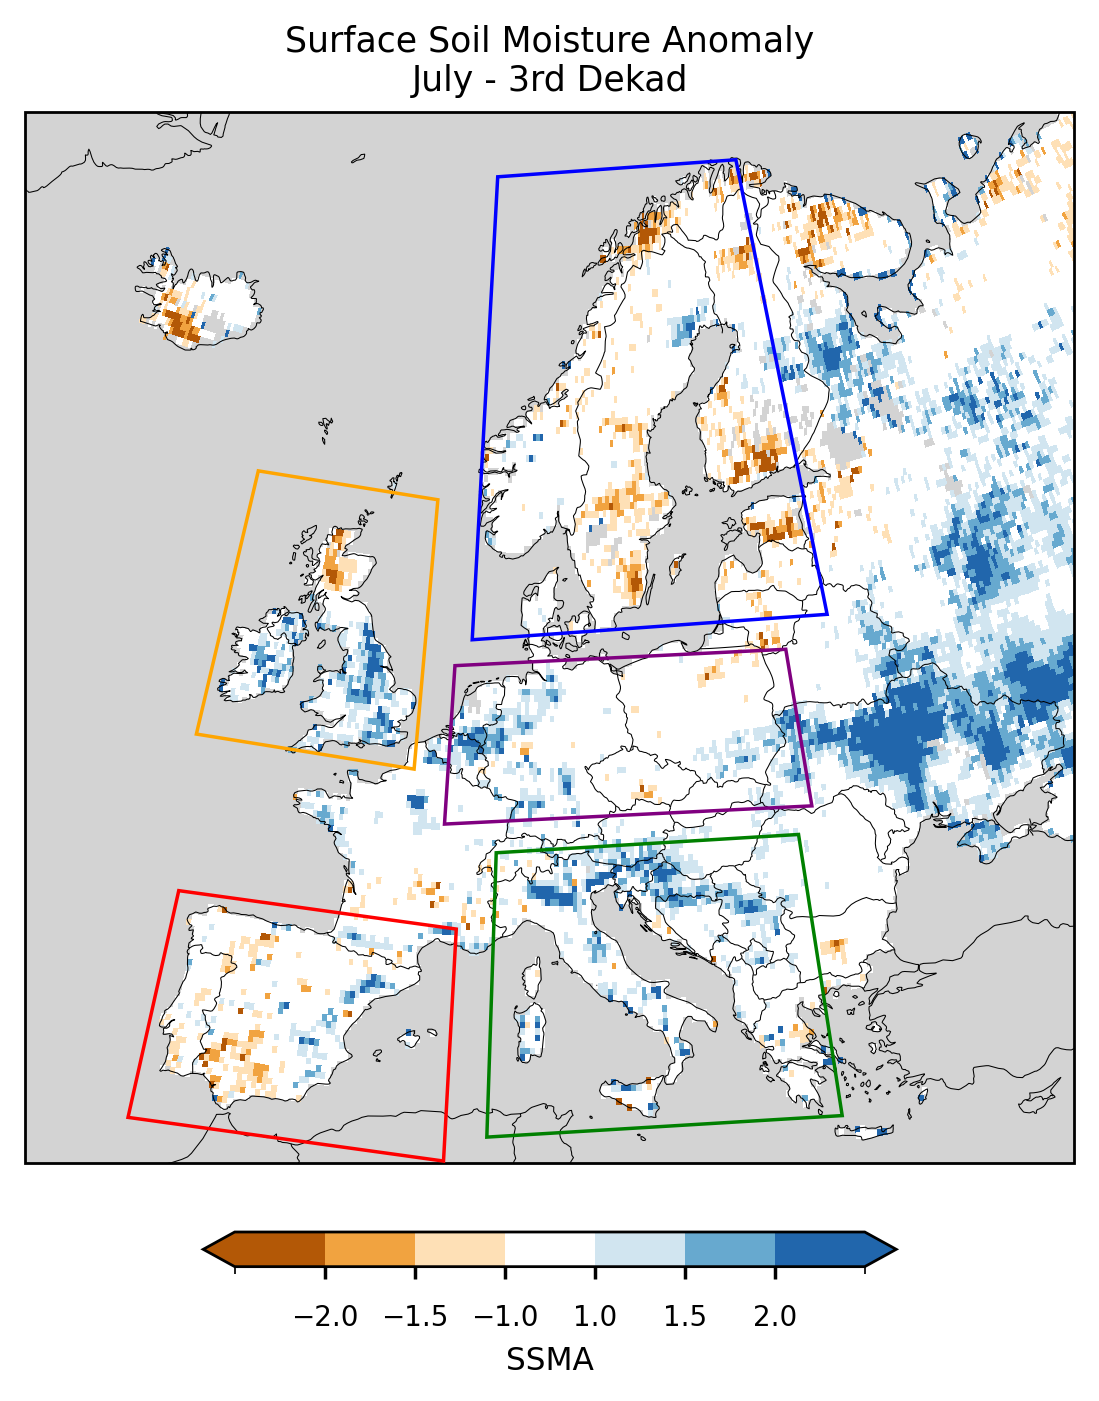

In [112]:
# Dekad DOYs and labels
dekad_days = [
    [91, 101, 111],    # April
    [121, 131, 141],   # May
    [152, 162, 172],   # June
    [182, 192, 202],   # July
]
month_labels = ['April', 'May', 'June', 'July']
dekad_labels = ['1st Dekad', '2nd Dekad', '3rd Dekad']

# Flatten DOYs and labels
all_doys = [doy for sublist in dekad_days for doy in sublist]
all_labels = [f"{month} - {dekad}" for month in month_labels for dekad in dekad_labels]

# === Create figure and axis ===
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.LambertConformal(central_longitude=10, central_latitude=50)}, dpi=250)
ax.set_extent([-15, 35, 35, 72], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightgray')


# === Add colored rectangles ===
def add_rectangles(ax):

    for box in boxes:
        width = box['max_lon'] - box['min_lon']
        height = box['max_lat'] - box['min_lat']
        rect = Rectangle(
            (box['min_lon'], box['min_lat']),
            width,
            height,
            linewidth=1,
            edgecolor=box['color'],
            facecolor='none',
            transform=ccrs.PlateCarree(),
            zorder=5
        )
        ax.add_patch(rect)

add_rectangles(ax)

# === Initial frame ===
sm_init = sma.sel(dayofyear=all_doys[0]).where(sma.sel(dayofyear=all_doys[0]) != 0, np.nan)
im = sm_init.plot(
    ax=ax, transform=ccrs.PlateCarree(),
    cmap=cmap, norm=norm, add_colorbar=False  # <- disable auto colorbar
)
title = ax.set_title(f"Surface Soil Moisture Anomaly\n{all_labels[0]}", fontsize=10)

# Define bounds and ticks

ticks = bounds[1:-1]

# Add manual shared colorbar
cbar = fig.colorbar(
    im, ax=ax, orientation='horizontal',
    fraction=0.03, pad=0.06, shrink=0.9,
    ticks=ticks, extend='both'
)
cbar.ax.tick_params(labelsize=8)          # Make tick numbers smaller
cbar.set_label('SSMA', fontsize=9)   


# === Animation update function ===
def update(frame_idx):
    doy = all_doys[frame_idx]
    label = all_labels[frame_idx]
    sm_doy = sma.sel(dayofyear=doy).where(sma.sel(dayofyear=doy) != 0, np.nan)
    im.set_array(sm_doy.values.flatten())  # Update the image data
    title.set_text(f"Surface Soil Moisture Anomaly\n{label}")
    return im,

# === Create and save animation ===
ani = animation.FuncAnimation(
    fig, update, frames=len(all_doys), blit=False, interval=1000
)

ani.save("/data/wp5/trigoso_camila/SoilMoisture/fig/soil_moisture_animv2.gif", writer='pillow', dpi=250)

plt.show()

```{figure} 91445788-f349-461a-bdfe-33fcf271d6ba.gif
---
name: fig-mapgif
figwidth: 100%
---
Surface soil moisture anomalies in Europe for the period of Spring to Mid-Summer 2023 accoridng to the C3S-SM-COMBINED data.
```

#### Regional SSMA plots

The mean SSMA of the regions marked by boxes in {numref}`fig-mapgif` were plotted over time.

In [122]:
def plot_sma_mean_over_region(
    sma_data,
    min_lat=35,
    max_lat=45,
    min_lon=-10,
    max_lon=5,
    start_doy=91,
    end_doy=202,
    title="Average Soil Moisture Anomaly over Iberian Peninsula",
    color="blue",
    year=2023  # specify year for converting DOY to date
):
    # Subset by region
    sma_subset = sma_data.sel(
        longitude=slice(min_lon, max_lon),
        latitude=slice(max_lat, min_lat)  # decreasing lat
    )

    # Ensure DOY values are valid
    available_doys = sma_subset.dayofyear.values
    target_doys = [doy for doy in available_doys if start_doy <= doy <= end_doy]

    if not target_doys:
        print(f"No matching DOYs in range {start_doy}–{end_doy}.")
        return

    # Subset by DOY
    sma_subset = sma_subset.sel(dayofyear=target_doys)

    # Mean over space
    sma_mean = sma_subset.mean(dim=["latitude", "longitude"], skipna=True)

    # Convert DOY to date
    date_index = pd.to_datetime([f"{year}-{doy}" for doy in sma_mean.dayofyear.values], format="%Y-%j")

    # Plot
    plt.figure(figsize=(10, 4), dpi=250)
    plt.plot(date_index, sma_mean, marker='o', linestyle='-', color=color)
    plt.title(f"{title}\n{date_index[0].strftime('%b %d')} to {date_index[-1].strftime('%b %d')}")
    plt.xlabel("Date")
    plt.ylabel("Mean SSMA")
    plt.grid(True)

    # Create custom ticks on 1st, 11th, 21st of each month
    tick_days = [1, 11, 21]
    tick_dates = pd.date_range(start=date_index[0], end=date_index[-1], freq='D')
    custom_ticks = [d for d in tick_dates if d.day in tick_days]
    
    # Set custom ticks and labels
    plt.xticks(custom_ticks, [d.strftime('%b %d') for d in custom_ticks], rotation=45)

    # Highlight 0 line
    plt.axhline(0, color='black', linestyle='--', linewidth=1.5, label='Normal (SSMA=0)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"/data/wp5/trigoso_camila/SoilMoisture/fig/sm_region_{box['label']}.png", dpi=250, bbox_inches="tight")
    plt.show()

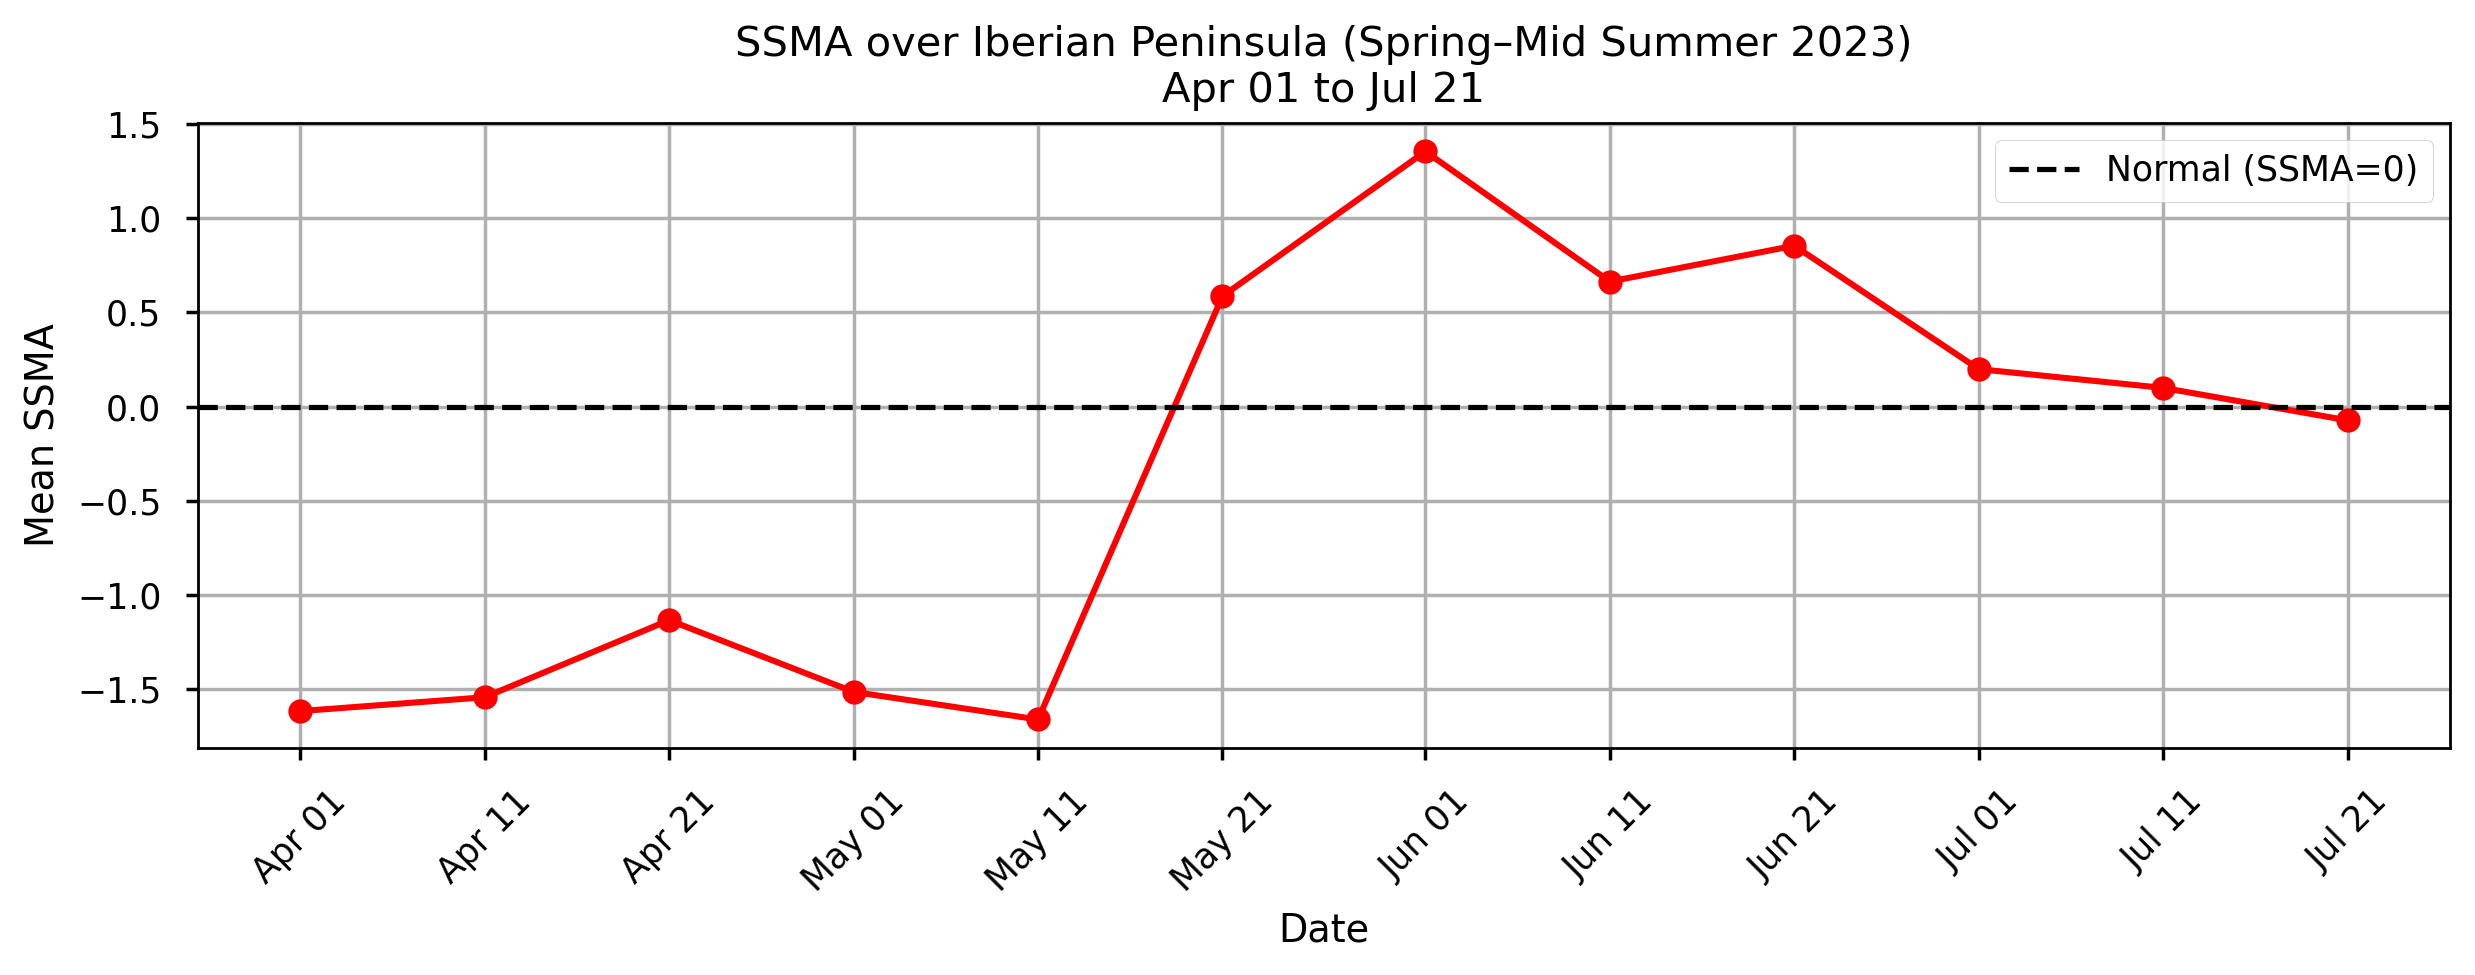

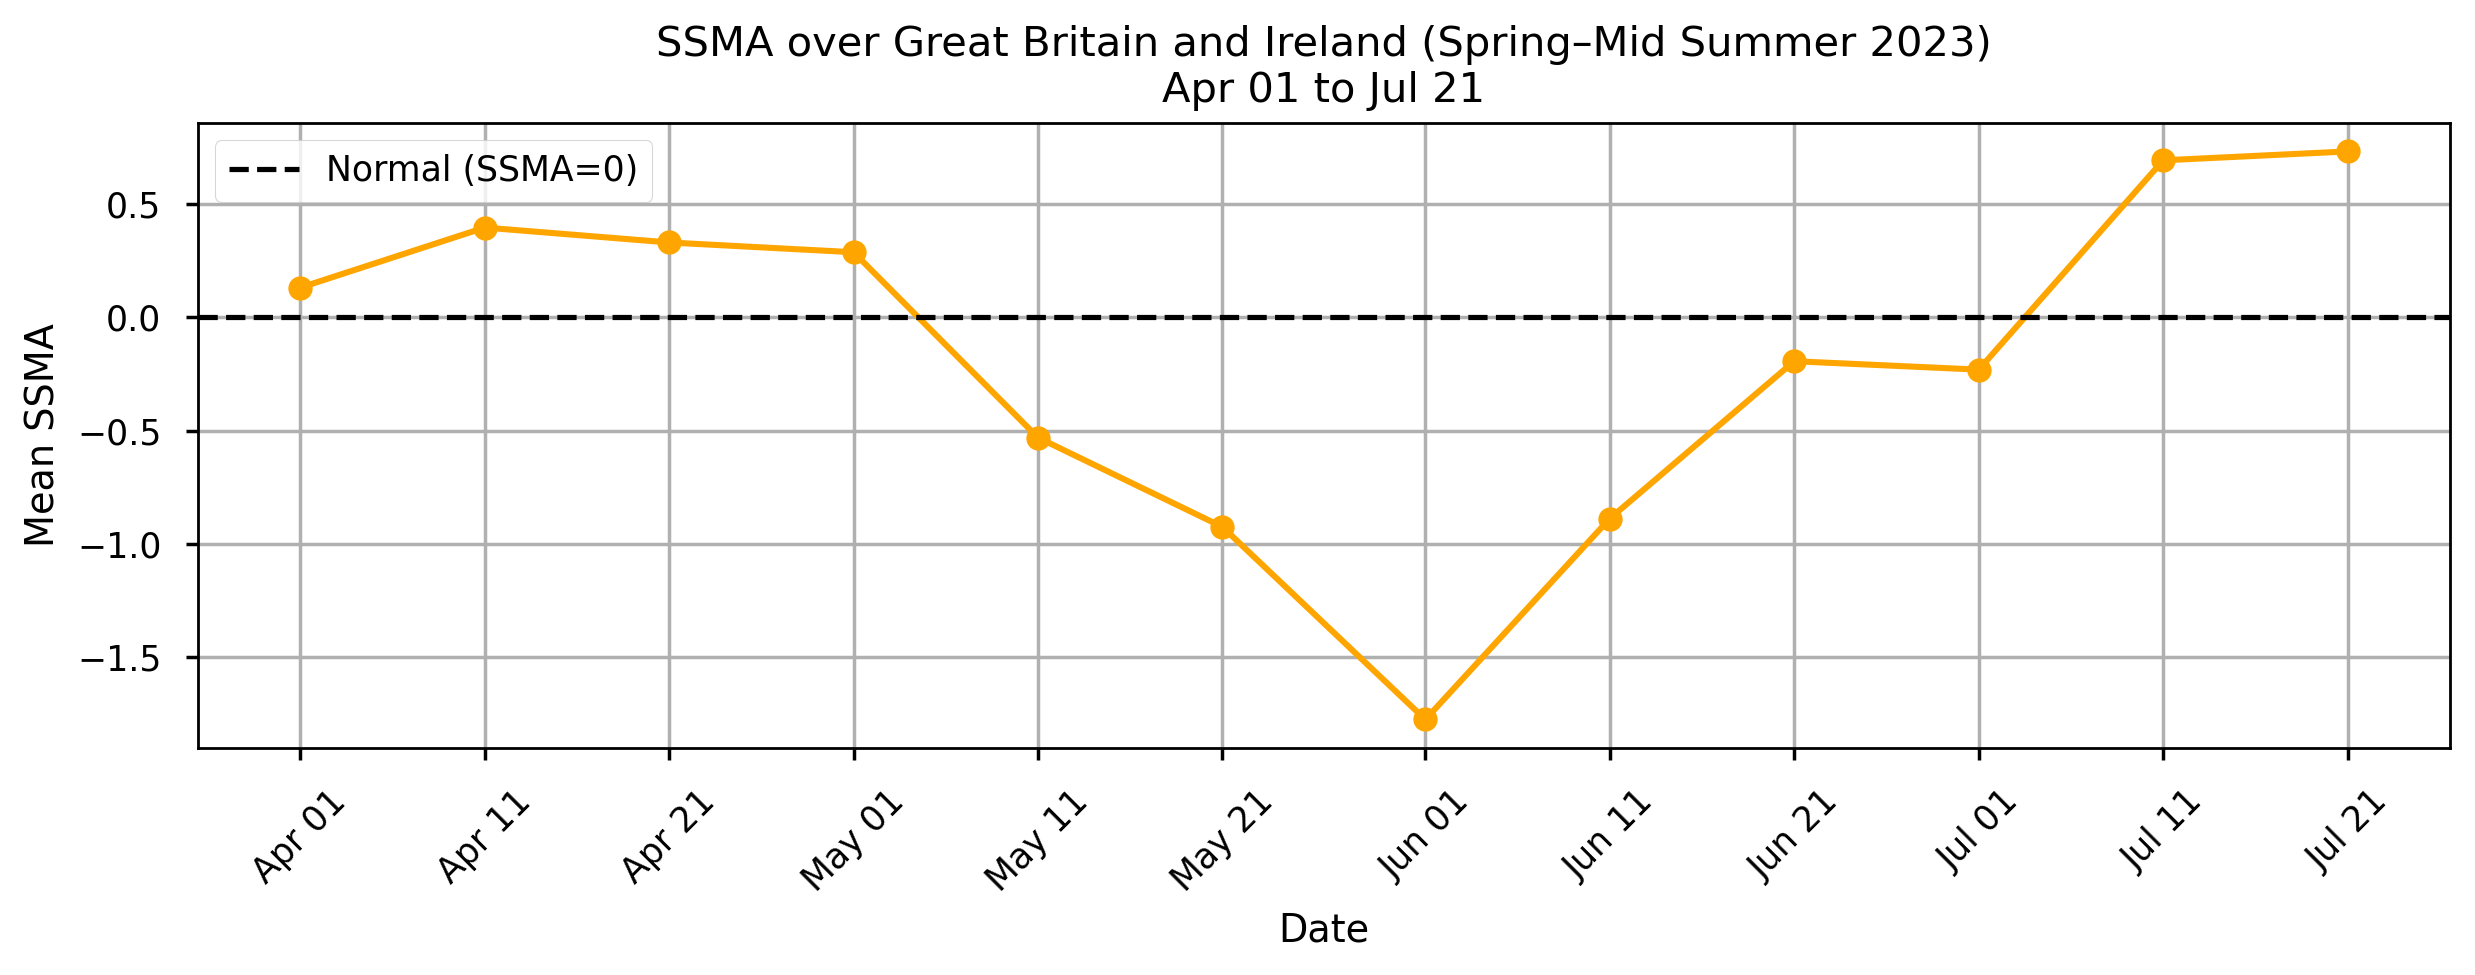

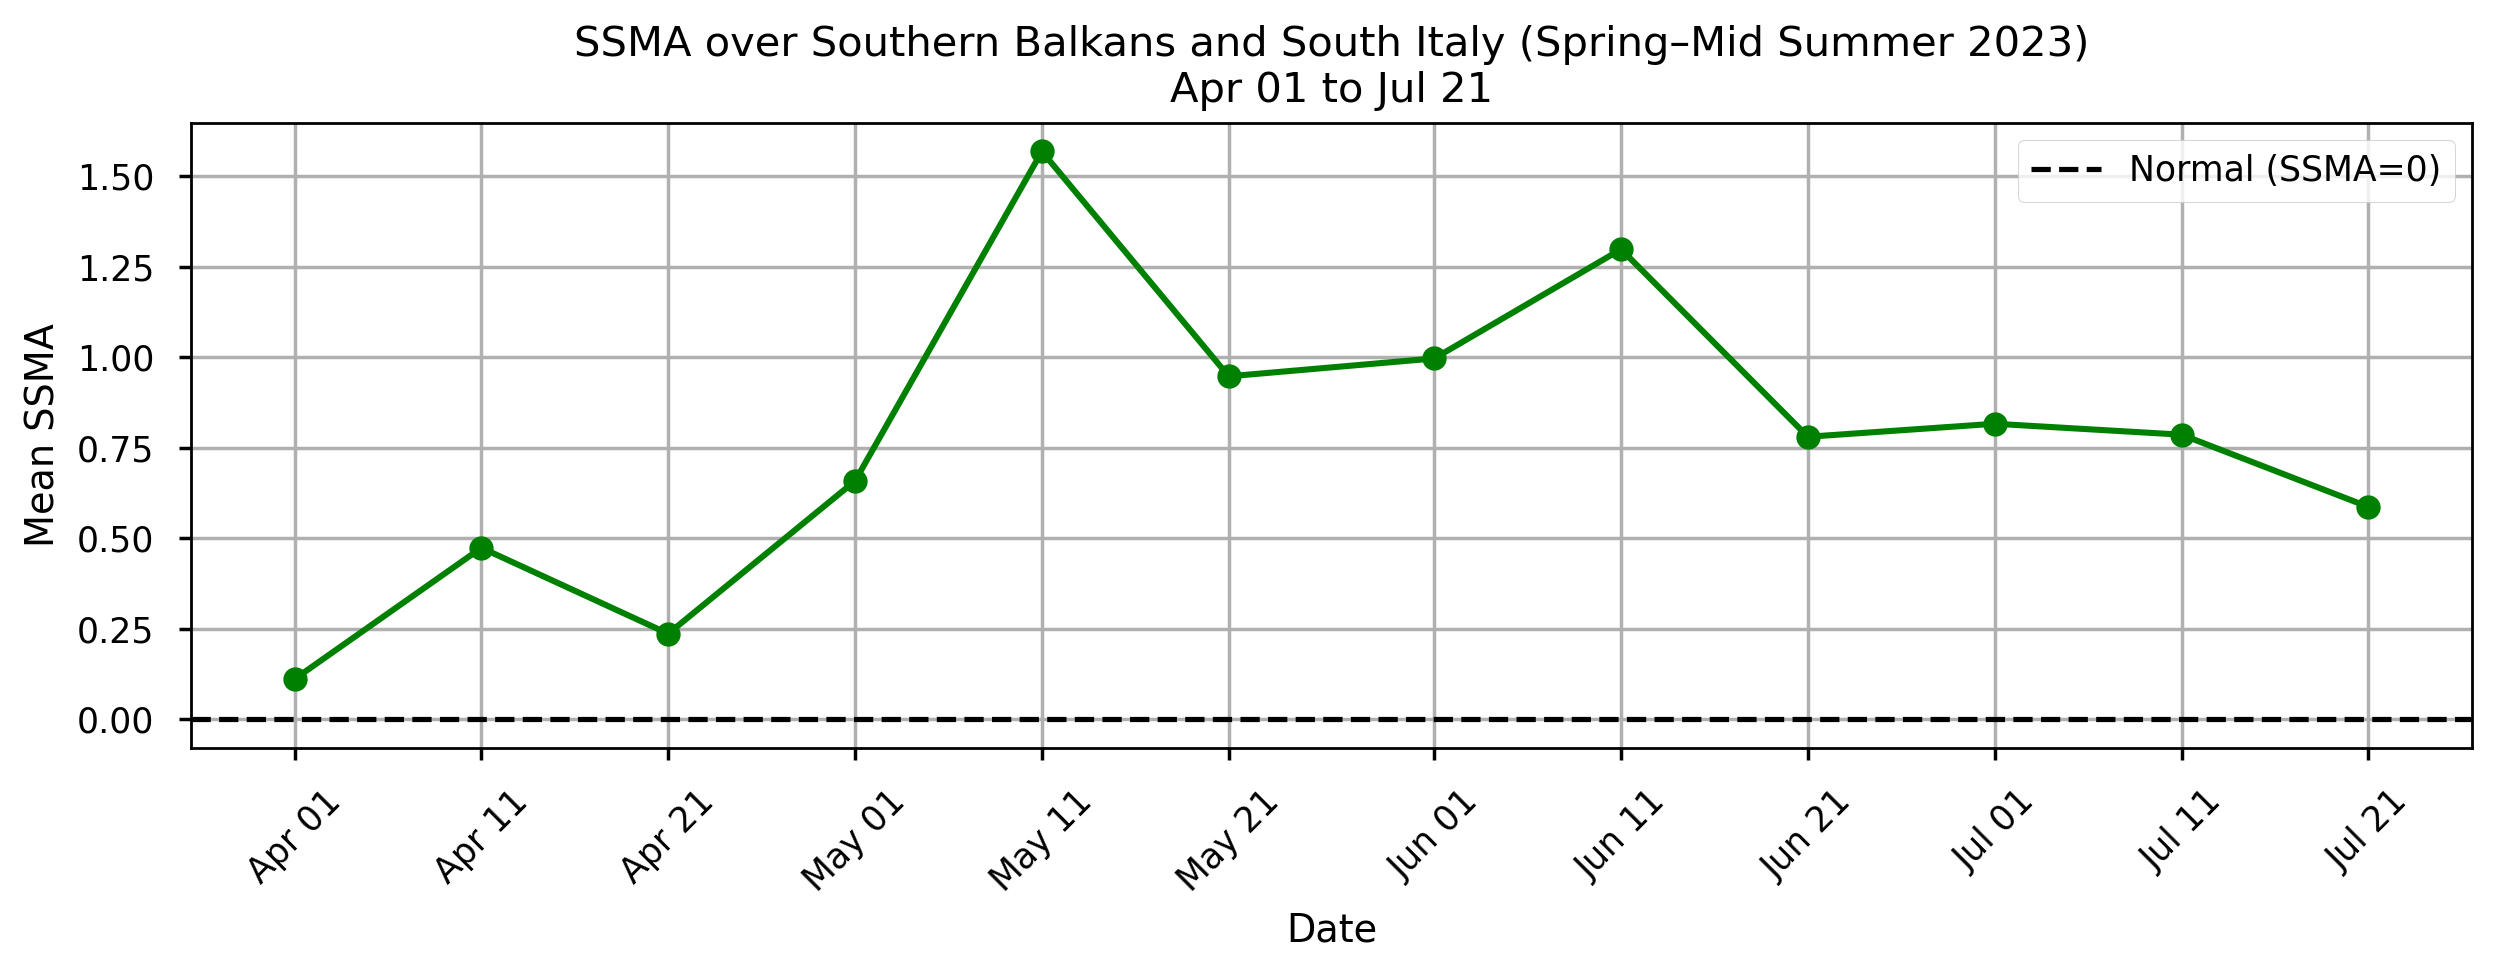

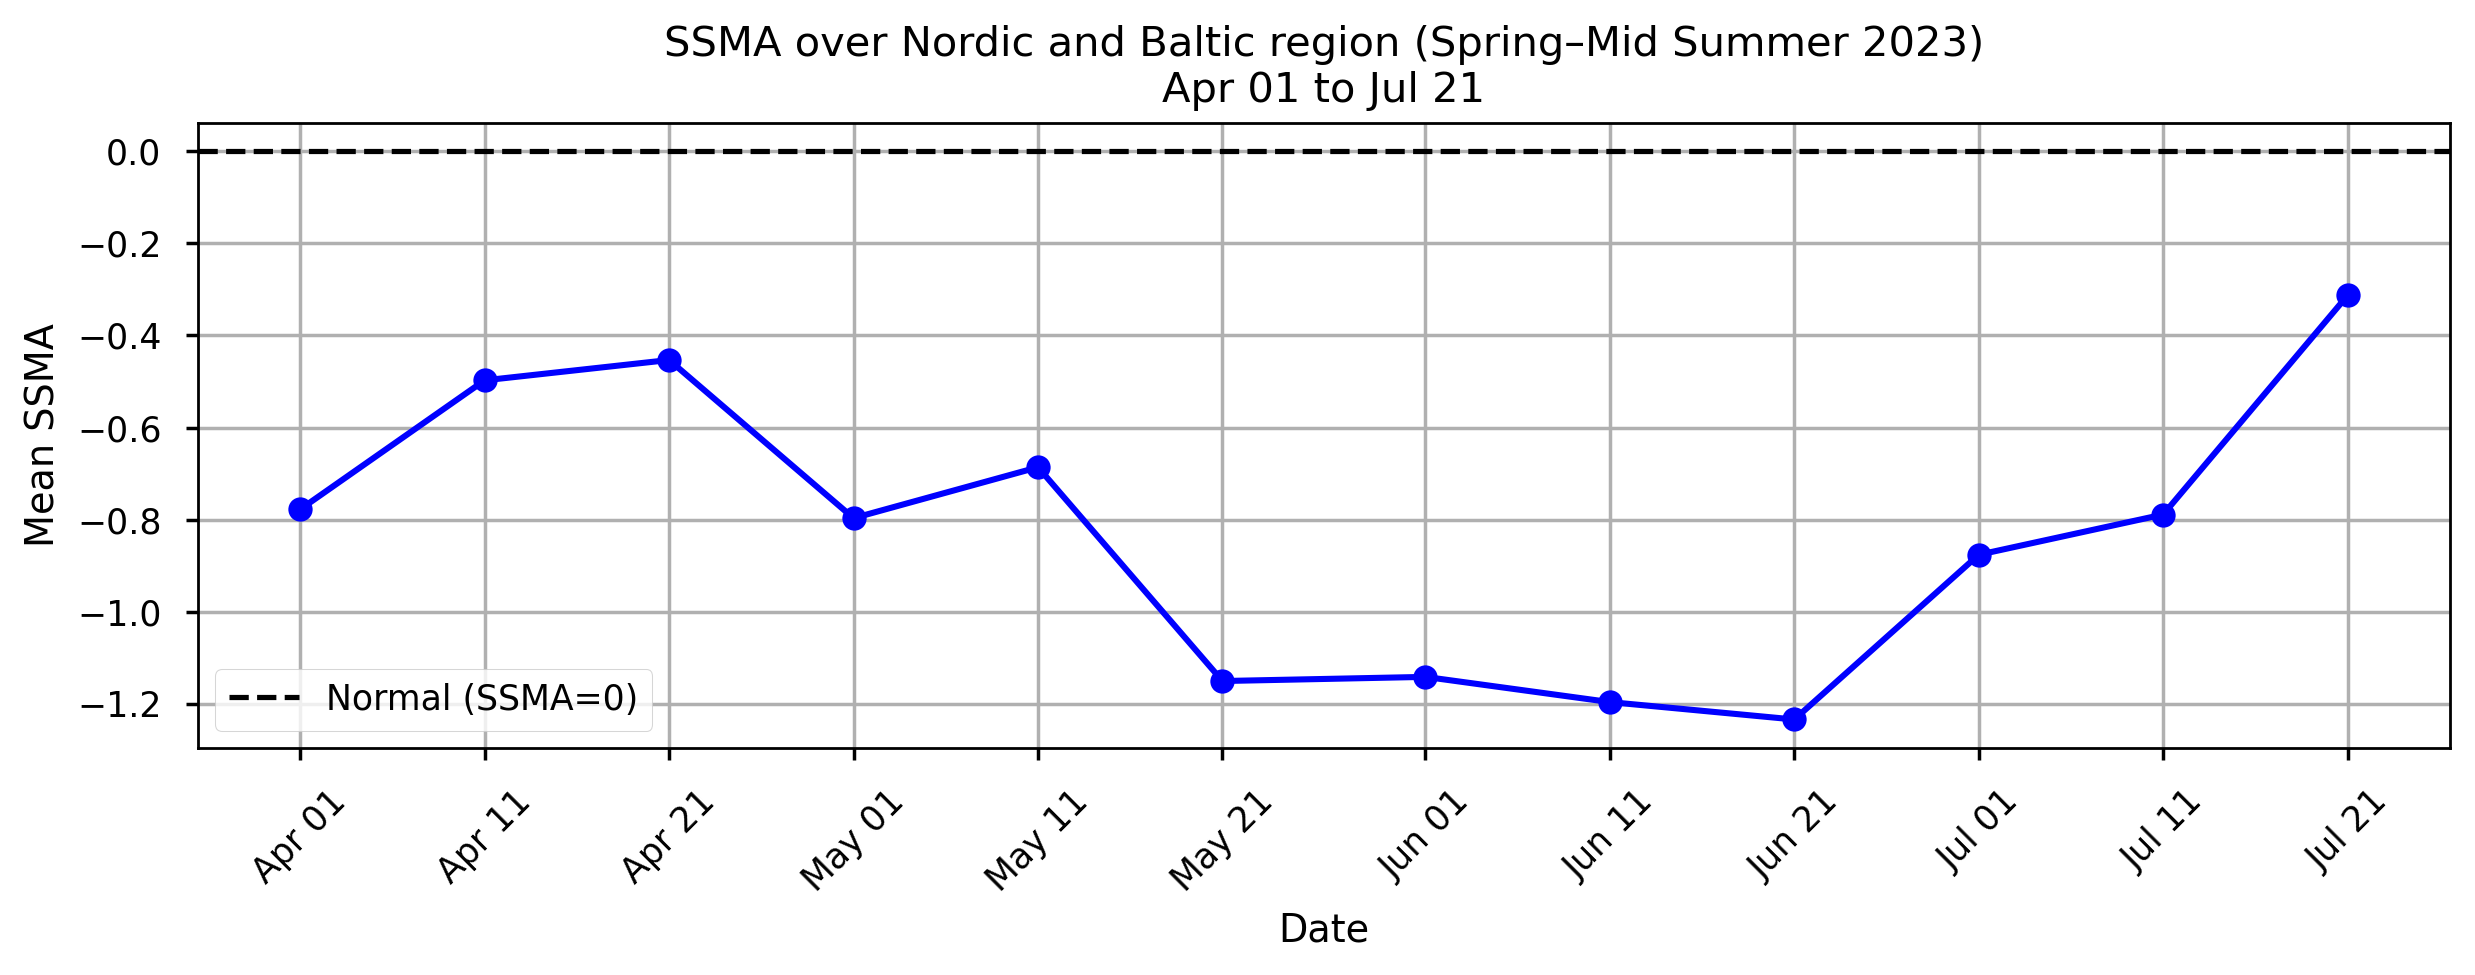

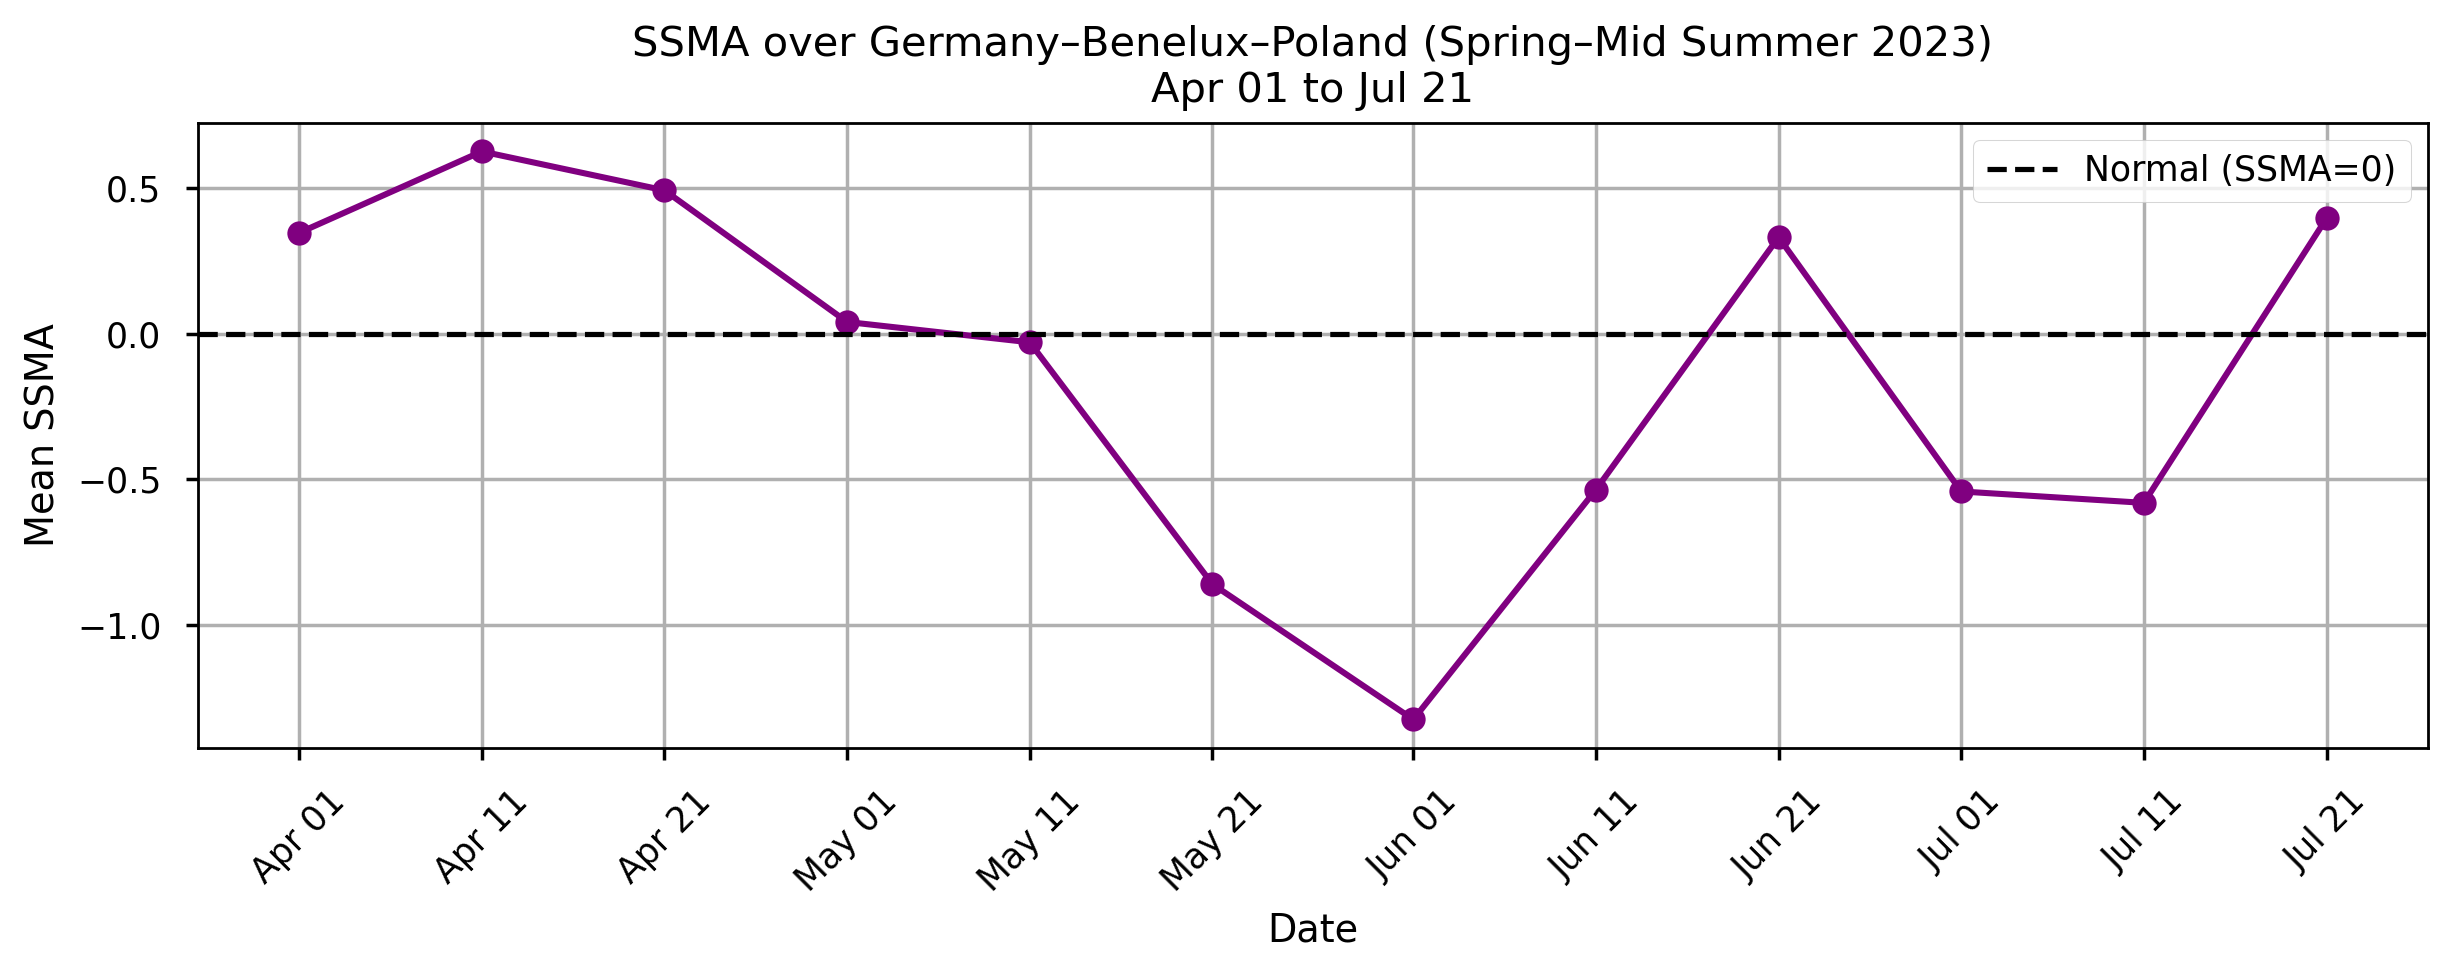

In [123]:
for box in boxes:
    plot_sma_mean_over_region(
        sma_data=sma,
        min_lat=box['min_lat'],
        max_lat=box['max_lat'],
        min_lon=box['min_lon'],
        max_lon=box['max_lon'],
        start_doy=91,
        end_doy=202,
        title=f"SSMA over {box['label']} (Spring–Mid Summer 2023)",
        color=box['color']
    )


```{figure} d81f09f9-b43a-42f8-a535-c124c00064a7.png
---
name: fig-iberian
figwidth: 100%
---
Surface soil moisture anomalies in the Iberian Peninsula for the period of Spring to Mid-Summer 2023 accoridng to the C3S-SM-COMBINED data.
```


```{figure} 372ed1ff-109e-422d-a6da-f9ed7c3cce43.png
---
name: fig-italy
figwidth: 100%
---
Surface soil moisture anomalies in the Southern Balkans and South Italy for the period of Spring to Mid-Summer 2023 accoridng to the C3S-SM-COMBINED data.
```

On top of low rainfall, a significant spring heatwave amplified drought conditions in the western Mediterranean in April 2023  [[2]](https://www.nature.com/articles/s41612-024-00569-6). According to the European Commission (2023) [[3]](https://joint-research-centre.ec.europa.eu/jrc-news-and-updates/severe-drought-western-mediterranean-faces-low-river-flows-and-crop-yields-earlier-ever-2023-06-13_en) the Combined Drought Indicator (CDI) showed warning and alert conditions across much of the western Mediterranean by mid-May, with drought conditions worse than those observed at the same time of the year in 2022. This situation is reflected in the SSMA results for the Iberian Peninsula (see {numref}`fig-iberian`) The SSMA was notably negative, around -1.5 standard deviations, from April to mid-May. After late May, SSMA values increased, turning positive and gradually approaching normal conditions (near 0).

In contrast, crop-growing conditions improved in the Balkans, Italy, France, and Turkey during the same period [[3]](https://joint-research-centre.ec.europa.eu/jrc-news-and-updates/severe-drought-western-mediterranean-faces-low-river-flows-and-crop-yields-earlier-ever-2023-06-13_en). The European Commission also reported flooding in parts of Italy and the western Balkans in May 2023, caused by heavy precipitation [[5]](https://climate.copernicus.eu/precipitation-relative-humidity-and-soil-moisture-may-2023). This is consistent with observations in {numref}`fig-italy`, where the SSMA in southern Italy and the southern Balkans was strongly positive, reaching values above +1.5 standard deviations by mid-May.


```{figure} 4821267f-756f-49e4-9dce-82925b64f704.png
---
name: fig-uk
figwidth: 100%
---
Surface soil moisture anomalies in Great Britain and Ireland for the period of Spring to Mid-Summer 2023 accoridng to the C3S-SM-COMBINED data.
```


```{figure} b983cb7f-b5d5-4990-b618-035b3e879822.png
---
name: fig-central
figwidth: 100%
---
Surface soil moisture anomalies in Germany–Benelux–Poland for the period of Spring to Mid-Summer 2023 accoridng to the C3S-SM-COMBINED data.
```

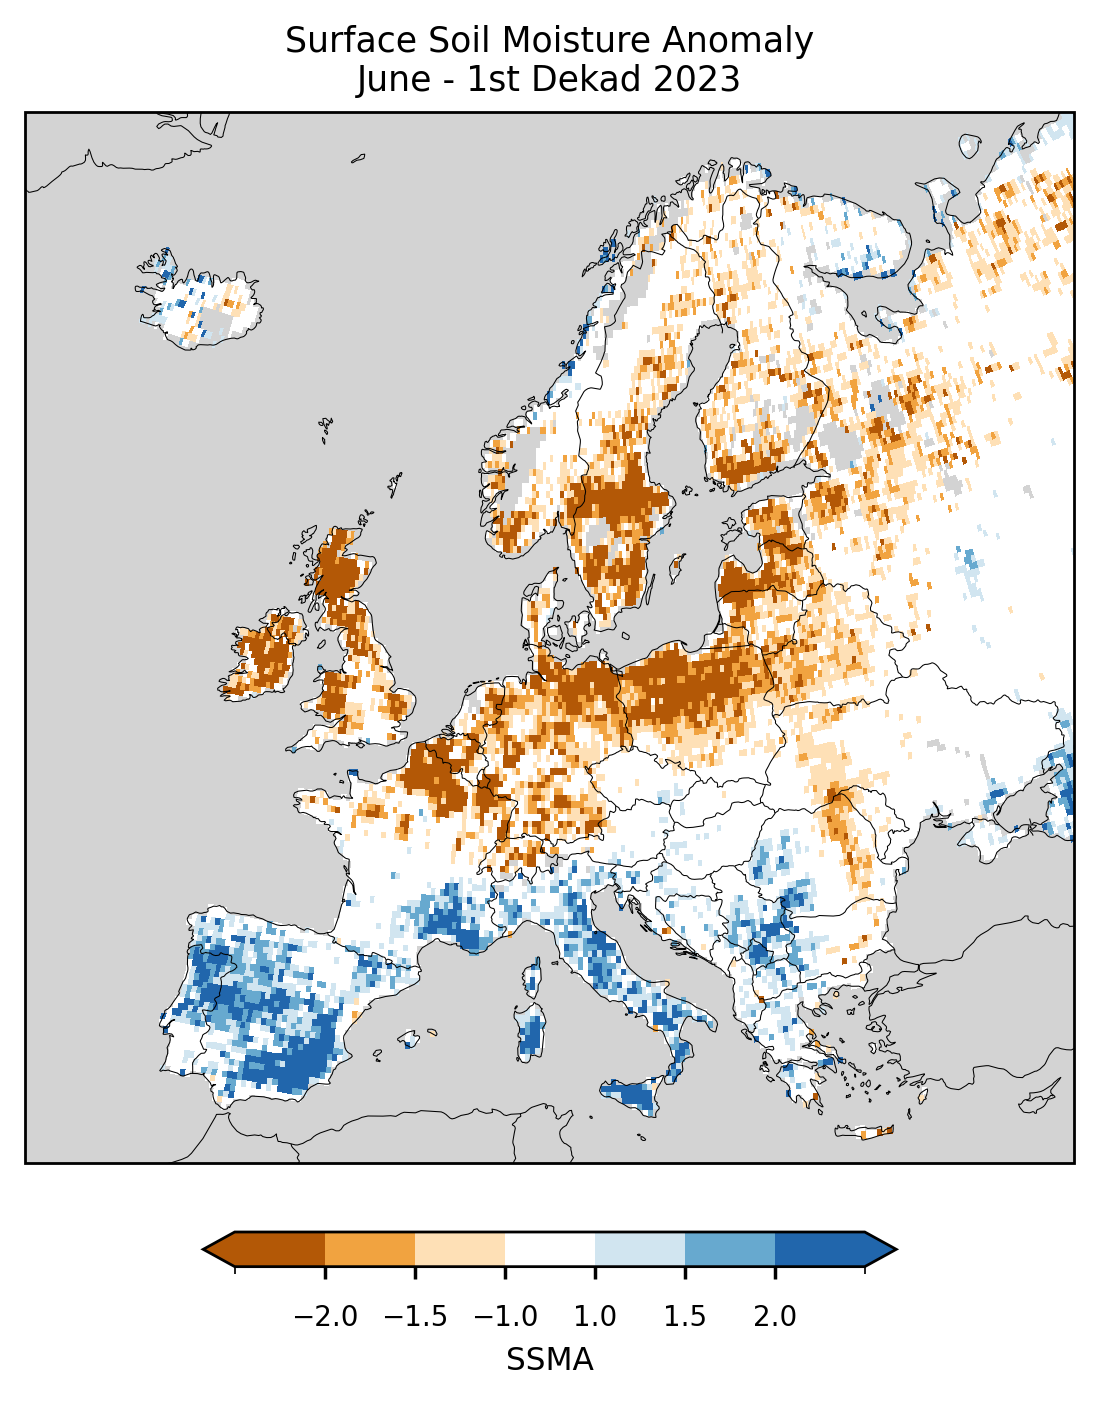

In [127]:
# === Choose specific year and DOY ===
chosen_year = 2023
chosen_doy = 152  # 1st Dekad of June

# === Extract data ===
sm_single = sma.sel(dayofyear=chosen_doy).where(
    sma.sel(dayofyear=chosen_doy) != 0, np.nan
)
# === Create figure and axis ===
fig, ax = plt.subplots(
    figsize=(8, 6),
    subplot_kw={'projection': ccrs.LambertConformal(central_longitude=10, central_latitude=50)},
    dpi=250
)
ax.set_extent([-15, 35, 35, 72], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightgray')

# === Plot soil moisture ===
im = sm_single.plot(
    ax=ax, transform=ccrs.PlateCarree(),
    cmap=cmap, norm=norm, add_colorbar=False
)

# === Add title ===
month_idx = next(i for i, sublist in enumerate(dekad_days) if chosen_doy in sublist)
dekad_idx = dekad_days[month_idx].index(chosen_doy)
label = f"{month_labels[month_idx]} - {dekad_labels[dekad_idx]}"
ax.set_title(f"Surface Soil Moisture Anomaly\n{label} {chosen_year}", fontsize=10)

# === Add colorbar ===
ticks = bounds[1:-1]
cbar = fig.colorbar(
    im, ax=ax, orientation='horizontal',
    fraction=0.03, pad=0.06, shrink=0.9,
    ticks=ticks, extend='both'
)
cbar.ax.tick_params(labelsize=8)
cbar.set_label('SSMA', fontsize=9)

# === Save the figure ===
plt.savefig(f"/data/wp5/trigoso_camila/SoilMoisture/fig/ssma_{chosen_year}_{chosen_doy}.png", dpi=250)

plt.show()


```{figure} c01fcf81-aca2-4d01-a0d7-6f92db0a18d9.png
---
name: fig-june
figwidth: 100%
---
a) SSMA in early-June 2023 accoridng to the C3S-SM-COMBINED data. b) SMI Anomaly in early-June 2023 accoridng to the EDO, generated using Copernicus Emergency Management Service information (2025) [[7]](https://drought.emergency.copernicus.eu/tumbo/edo/map/).
```

Great Britain, Ireland, and much of central Europe exhibited a notable negative SSMA peak at the beginning of June (see  {numref}`fig-uk` and {numref}`fig-central`). This pattern aligns with reports that much of central and northern Europe experienced drier-than-normal conditions in June 2023 [[6]](https://op.europa.eu/en/publication-detail/-/publication/73bf18ea-2449-11ee-94cb-01aa75ed71a1/language-en).

{numref}`fig-june` (b) shows the Soil Moisture Index (SMI) Anomaly for early June, generated by the EDO  [[7]](https://drought.emergency.copernicus.eu/tumbo/edo/map/). This index is obtained using the LISFLOOD model, which "simulates soil moisture in two surface layers (skin layer and root zone) separately for forested and other layers. These four soil moisture layers are averaged daily to derive a single mean root zone soil moisture conditions to be successively standardized into SMI" [[1]](https://drought.emergency.copernicus.eu/data/factsheets/factsheet_soilmoisture.pdf).

While both the LISFLOOD model and the satellite-derived C3S-SM-COMBINED product reflect general drought trends, differences emerge due to what each system measures. C3S observations represent only the top centimeters of the soil (surface layer), which respond more quickly to short-term precipitation events. LISFLOOD, on the other hand, also takes into account the deeper root zone, which changes more slowly and captures longer-term drought stress.

As a result, while the C3S product shows wetter-than-usual surface soil moisture anomalies in the Iberian Peninsula by early June, LISFLOOD still indicates drier-than-normal conditions due to lingering root-zone deficits. Conversely, in central Europe (e.g., Benelux and Germany), C3S data show negative anomalies whereas LISFLOOD depicts mostly normal conditions, with only some patches of dryness.

Surface soil moisture is particularly useful for monitoring rapid changes on a regional scale. However, for agricultural drought monitoring, it is important to also consider long-term and subsurface moisture conditions, as reflected in root-zone models like LISFLOOD.



```{figure} 372978d8-d7d9-4c4f-bfea-443e5f496eba.png
---
name: fig-nordic
figwidth: 100%
---
Surface soil moisture anomalies in the Nordic and Baltic region for the period of Spring to Mid-Summer 2023 accoridng to the C3S-SM-COMBINED data.
```

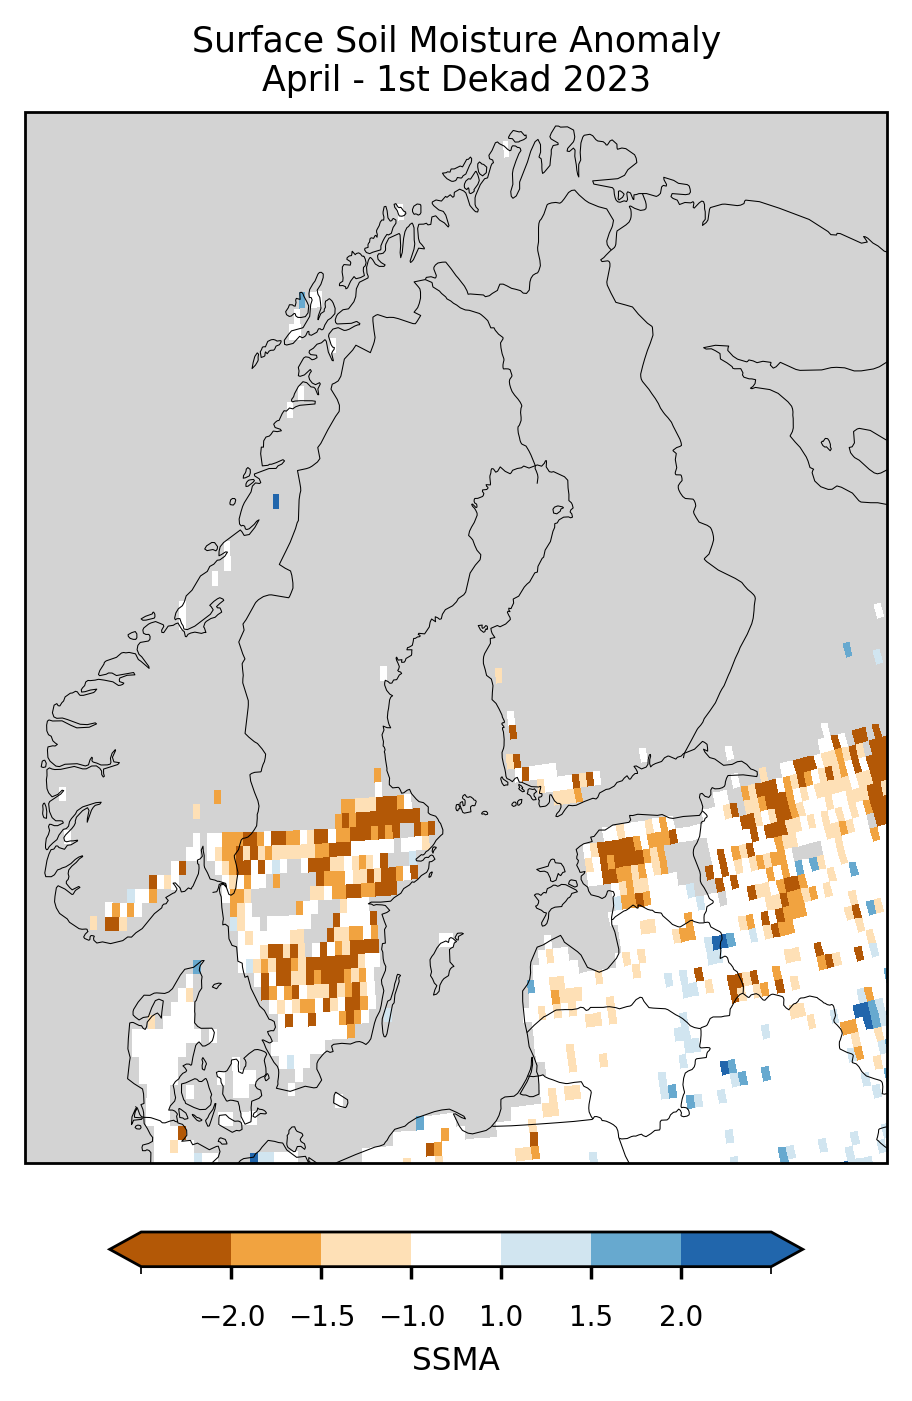

In [129]:
# === Choose specific year and DOY ===
chosen_year = 2023
chosen_doy = 91  # 1st Dekad of April

# === Extract data ===
sm_single = sma.sel(dayofyear=chosen_doy).where(
    sma.sel(dayofyear=chosen_doy) != 0, np.nan
)
# === Create figure and axis ===
fig, ax = plt.subplots(
    figsize=(8, 6),
    subplot_kw={'projection': ccrs.LambertConformal(central_longitude=10, central_latitude=50)},
    dpi=250
)
ax.set_extent([5, 32, 54, 71], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightgray')

# === Plot soil moisture ===
im = sm_single.plot(
    ax=ax, transform=ccrs.PlateCarree(),
    cmap=cmap, norm=norm, add_colorbar=False
)

# === Add title ===
month_idx = next(i for i, sublist in enumerate(dekad_days) if chosen_doy in sublist)
dekad_idx = dekad_days[month_idx].index(chosen_doy)
label = f"{month_labels[month_idx]} - {dekad_labels[dekad_idx]}"
ax.set_title(f"Surface Soil Moisture Anomaly\n{label} {chosen_year}", fontsize=10)

# === Add colorbar ===
ticks = bounds[1:-1]
cbar = fig.colorbar(
    im, ax=ax, orientation='horizontal',
    fraction=0.03, pad=0.06, shrink=0.9,
    ticks=ticks, extend='both'
)
cbar.ax.tick_params(labelsize=8)
cbar.set_label('SSMA', fontsize=9)

# === Save the figure ===
plt.savefig(f"/data/wp5/trigoso_camila/SoilMoisture/fig/ssma_{chosen_year}_{chosen_doy}.png", dpi=250)

plt.show()


```{figure} 6c918ede-6757-4788-bd75-066f6a02e9db.png
---
name: fig-nordicapril
figwidth: 80%
---
Surface soil moisture anomalies in the Nordic and Baltic region for the period in the first dekad of April 2023 accoridng to the C3S-SM-COMBINED data.
```


{numref}`fig-nordic` shows that the Scandinavian Peninsula, as well as the Nordic and Baltic countries, were unusually dry during mid-spring and early summer 2023. However, the data for these regions in April is notably incomplete (see {numref}`fig-nordicapril`). During this period, valid soil moisture data are available only for the southernmost parts of the Scandinavian Peninsula. This lack of data can be attributed to the presence of snow cover and frozen soil still during spring. According to [PUGS](https://confluence.ecmwf.int/pages/viewpage.action?pageId=445290955), the C3S Surface Soil Moisture v202312 product cannot retrieve meaningful data when the ground is snow-covered or frozen. Under such conditions, the dielectric properties of water change significantly, making satellite-based retrieval unreliable.

The results shown in this section are consistent with those presented in the European State of the Climate 2023 by Copernicus [[4]](https://climate.copernicus.eu/esotc/2023/soil-moisture). However, while that report presents monthly data using the C3S v202212 PASSIVE dataset, this analysis is based on a dekadal (10-day) data and uses the COMBINED v202312 product.

## ℹ️ If you want to know more

* Markonis, Y., Kumar, R., Hanel, M., Rakovec, O., Máca, P., & AghaKouchak, A. (2021). The rise of compound warm-season droughts in Europe. Science Advances, 7(6), eabb9668. [](https://doi.org/10.1126/sciadv.abb9668)
* Ministerio para la Transición Ecológica y el Reto Demográfico (2023). El 14,6% del territorio está en emergencia por escasez de agua y el 27,4%, en alerta. Nota de prensa. [](https://www.miteco.gob.es/es/prensa/ultimas-noticias/2023/09/el-14-6--del-territorio-esta-en-emergencia-por-escasez-de-agua-y.html)
* Laguardia, G. & Niemeyer, S. (2008). On the comparison between the LISFLOOD modelled and the ERS/SCAT derived soil moisture estimates. Hydrol. Earth Syst. Sci., 12, 1339–1351. [](https://hess.copernicus.org/articles/12/1339/2008/)

### Key resources

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)

Dataset documentation:
[SM v202212: Product User Guide and Specification (PUGS)](https://confluence.ecmwf.int/pages/viewpage.action?pageId=355349314)

[SM v202312: Algorithm Theoretical Basis Document (ATBD)](https://confluence.ecmwf.int/pages/viewpage.action?pageId=453676750)

[SM v202312: Product Quality Assurance Document (PQAD)](https://confluence.ecmwf.int/pages/viewpage.action?pageId=445290971)

### References


[[1]](https://drought.emergency.copernicus.eu/data/factsheets/factsheet_soilmoisture.pdf) European Commission (2019). EDO INDICATOR FACTSHEET Soil Moisture Anomaly (SMA). European Drought Observatory.

[[2]](https://www.nature.com/articles/s41612-024-00569-6) Lemus-Canovas, M., Insua-Costa, D., Trigo, R. & Miralles, D. (2024). Record-shattering 2023 Spring heatwave in western Mediterranean amplified by long-term drought. npj Clim Atmos Sci 7, 25.

[[3]](https://joint-research-centre.ec.europa.eu/jrc-news-and-updates/severe-drought-western-mediterranean-faces-low-river-flows-and-crop-yields-earlier-ever-2023-06-13_en) European Commission (2023a). Severe drought: western Mediterranean faces low river flows and crop yields earlier than ever. European Drought Observatory. The Joint Research Centre: EU Science Hub.

[[4]](https://climate.copernicus.eu/esotc/2023/soil-moisture) European Commission (2023b). Europe in 2023 Soil Moisture.

[[5]](https://climate.copernicus.eu/precipitation-relative-humidity-and-soil-moisture-may-2023) European Commission (2023c). Precipitation, relative humidity and soil moisture for May 2023.

[[6]](https://op.europa.eu/en/publication-detail/-/publication/73bf18ea-2449-11ee-94cb-01aa75ed71a1/language-en) Toreti, A., Bavera, D., Acosta Navarro, J., Arias-Muñoz, C., Barbosa, P., De Jager, A., Di Ciollo, C., Fioravanti, G., Grimaldi, S., Hrast Essenfelder, A., Maetens, W., Magni, D., Masante, D., Mazzeschi, M., Mccormick, N. & Salamon, P. (2023). Drought in Europe June 2023. Publications Office of the European Union, Luxembourg, 2023, doi:10.2760/575433, JRC134492.

[[7]](https://drought.emergency.copernicus.eu/tumbo/edo/map/) Copernicus Emergency Management Service (2025). European Drought Observatory map.

